Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip "/content/gdrive/MyDrive/CNN_assignment.zip"

Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images

data_dir_train = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


it can be seen there are a total of 2357 images with 2239 in train and 118 in test

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# create dataset object
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    subset='training',
    validation_split=0.2)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    subset='validation',
    validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

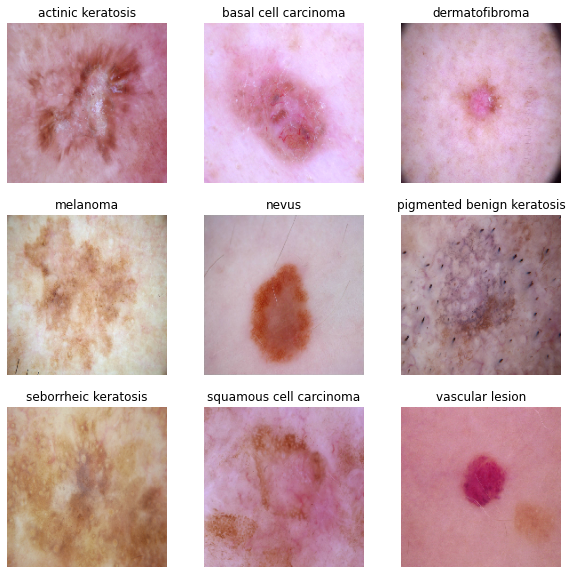

In [11]:
# Create a dictionary to store the paths of images for each class
files_path_dict = {c: [f"{data_dir_train}/{c}/{img}" for img in os.listdir(f"{data_dir_train}/{c}")] for c in class_names}

# Visualize images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i, (c, path_list) in enumerate(files_path_dict.items()):
    img = load_img(path_list[0], target_size=(img_height, img_width))
    axes[i].imshow(img)
    axes[i].set_title(c)
    axes[i].axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here

# Rescale the input layer by a factor of 1/255
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width,3))
])

# add convolutional layer with 32 filters and a kernel size of 3x3
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width,3)))

# add max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer with 64 filters and a kernel size of 3x3
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer with 128 filters and a kernel size of 3x3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(Flatten())

# add dense layer with 256 units and 'relu' activation
model.add(Dense(256, activation = "relu"))

# add dropout layer
model.add(Dropout(0.25))

# add output layer with 9 units and 'softmax' activation
model.add(Dense(9, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Compile the model
Choose an appropirate optimiser and loss function for model training <br>

'adam' optimizer is used and 'categorical_crossentropy' is used as loss function given multi class classification problem

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 98ms/step - loss: 2.0170 - accuracy: 0.2684 - val_loss: 1.7782 - val_accuracy: 0.3624
Epoch 2/20
56/56 [==============================] - 2s 44ms/step - loss: 1.6124 - accuracy: 0.4129 - val_loss: 1.6999 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 2s 44ms/step - loss: 1.5002 - accuracy: 0.4643 - val_loss: 1.4737 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 2s 44ms/step - loss: 1.4252 - accuracy: 0.5050 - val_loss: 1.3756 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3131 - accuracy: 0.5335 - val_loss: 1.6373 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 2s 44ms/step - loss: 1.2849 - accuracy: 0.5385 - val_loss: 1.4078 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.2091 - accuracy: 0.5809 - val_loss: 1.3790 - val_accuracy: 0.5347
Epoch 8/20
5

### Visualizing training results

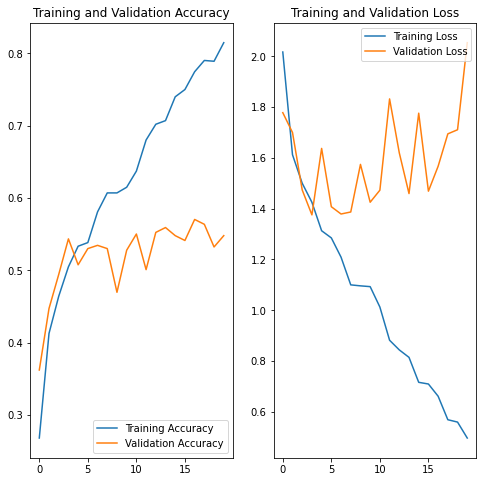

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## Findings
1. It can be seen that overfitting is happening as training accuracy is 81% while validation accuracy has plateued around 56% . The large difference in accuracy between training and validation points to overfitting
2. Will try augmenting existing data to improve model performance by reducing overfitting and increasing generalization of the model

## Augumentation strategy

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# data augumentation strategy using ImageDataGenerator and visualization
# Load the image
img = load_img('Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024435.jpg',target_size=(180,180))
plt.imshow(img)
plt.show()

# Convert the image to a numpy array
x = img_to_array(img)

# Reshape the array to have an extra dimension for the channel
x = x.reshape((1,) + x.shape)

# Create the image data generator
datagen = ImageDataGenerator(
    rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    #contrast_range=[0.5, 1.5],
    fill_mode='nearest')


## Visualization of Augumentation strategy

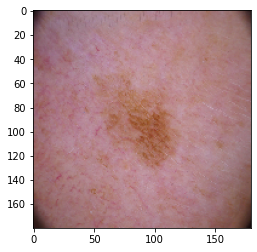

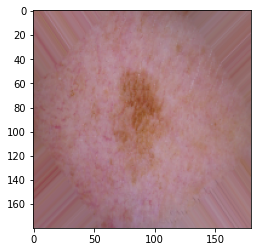

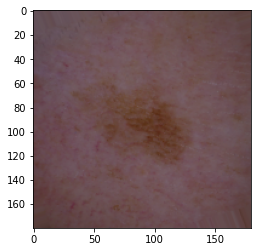

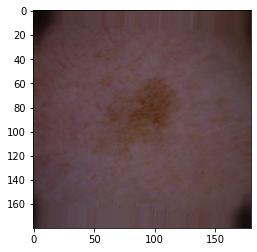

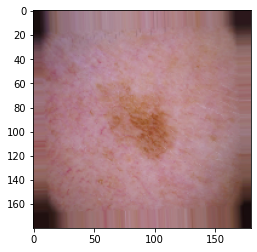

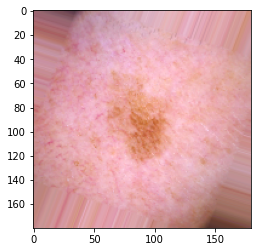

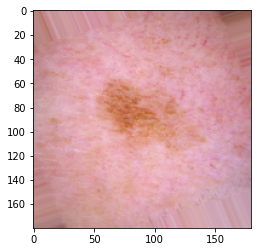

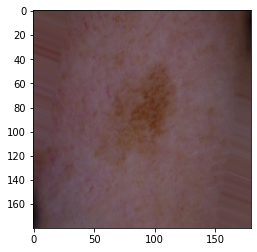

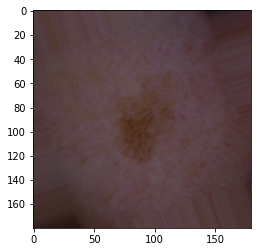

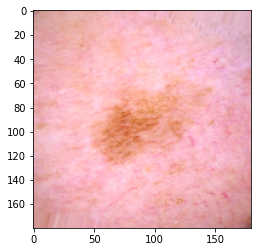

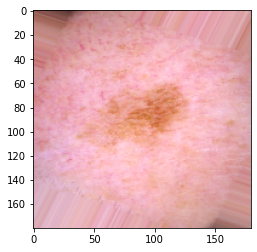

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

# Generate and view 10 transformed images
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(Image.fromarray(batch[0].astype('uint8')))
    i += 1
    if i % 10 == 0:
        break

plt.show()


### Todo:
### Create the model, compile and train the model


###  Augmentation of training data using ImageDataGenerator

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    validation_split=0.2)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_ds_aug = train_datagen.flow_from_directory(
    directory=data_dir_train,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    target_size=(img_height, img_width),
    seed=123,
    subset='training')

val_ds_aug = val_datagen.flow_from_directory(
    directory=data_dir_train,
    class_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    target_size=(img_height, img_width),
    seed=123,
    subset='validation')

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


### Create the model

In [19]:
# use augmented data to re-run the CNN model
# also added 1 dropout layer after dense layer for regularization

model = Sequential()

# add convolutional layer with 32 filters and a kernel size of 3x3
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width,3)))

# add max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer with 64 filters and a kernel size of 3x3
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer with 128 filters and a kernel size of 3x3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(Flatten())

# add dense layer with 256 units and 'relu' activation
model.add(Dense(256, activation = "relu"))

# add dropout layer
model.add(Dropout(0.25))

# add output layer with 9 units and 'softmax' activation
model.add(Dense(9, activation = "softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 22, 128)     

### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [21]:
epochs = 20
history = model.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 47s 822ms/step - loss: 2.1682 - accuracy: 0.1967 - val_loss: 1.8169 - val_accuracy: 0.3604
Epoch 2/20
57/57 [==============================] - 46s 802ms/step - loss: 1.8240 - accuracy: 0.3616 - val_loss: 1.6762 - val_accuracy: 0.4257
Epoch 3/20
57/57 [==============================] - 46s 798ms/step - loss: 1.5541 - accuracy: 0.4568 - val_loss: 1.7591 - val_accuracy: 0.4302
Epoch 4/20
57/57 [==============================] - 46s 806ms/step - loss: 1.4954 - accuracy: 0.4591 - val_loss: 1.8007 - val_accuracy: 0.3874
Epoch 5/20
57/57 [==============================] - 46s 808ms/step - loss: 1.4633 - accuracy: 0.4886 - val_loss: 1.9170 - val_accuracy: 0.3108
Epoch 6/20
57/57 [==============================] - 45s 790ms/step - loss: 1.4670 - accuracy: 0.4997 - val_loss: 1.9549 - val_accuracy: 0.4212
Epoch 7/20
57/57 [==============================] - 45s 795ms/step - loss: 1.4354 - accuracy: 0.4925 - val_loss: 1.8086 - val_accuracy: 0.4707

### Visualizing the results

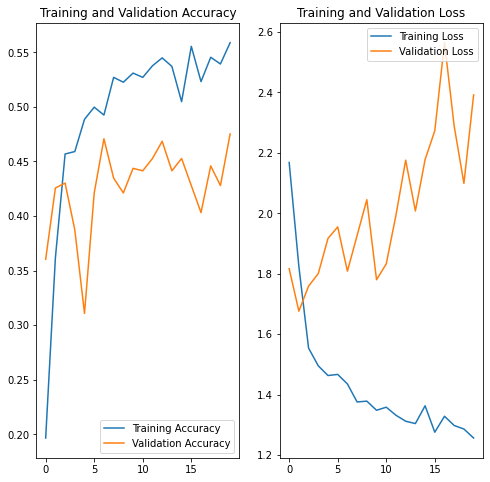

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. the training and validation accuracy are much closer now signifying that the problem of overfitting has reduced significantly by using data augmentation
2. however, the model accuracy hasn't improved much, and training time increased significantly
3. As an alternative we will use Kera preprocessing layers directly for data augmentation

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Alternative model with Keras preprocessing layers used for data augmentation

In [24]:
# rescaling and the 3 data augmentation steps are implemented using Keras preprocessing layers
# other than this the CNN architecture remains same as before

# Rescale the input layer by a factor of 1/255
# model = Sequential([
#                     layers.experimental.preprocessing.Rescaling(scale=1/255, input_shape=(img_height, img_width,3))
# ])

model = tf.keras.Sequential([
  layers.Rescaling(1./255,input_shape=(img_height, img_width,3)),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2,fill_mode='nearest'),
  layers.RandomZoom(height_factor=0.2,fill_mode='nearest')
])

# add convolutional layer with 32 filters and a kernel size of 3x3
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width,3)))

# add max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer with 64 filters and a kernel size of 3x3
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer with 128 filters and a kernel size of 3x3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(Flatten())

# add dense layer with 256 units and 'relu' activation
model.add(Dense(256, activation = "relu"))

# add dropout layer
model.add(Dropout(0.25))

# add output layer with 9 units and 'softmax' activation
model.add(Dense(9, activation = "softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                  

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [25]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 72ms/step - loss: 1.8754 - accuracy: 0.3198 - val_loss: 1.9867 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 4s 68ms/step - loss: 1.6166 - accuracy: 0.4269 - val_loss: 1.5297 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.4978 - accuracy: 0.4682 - val_loss: 1.4588 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 4s 68ms/step - loss: 1.4098 - accuracy: 0.4983 - val_loss: 1.3812 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 4s 68ms/step - loss: 1.3668 - accuracy: 0.5234 - val_loss: 1.3279 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 4s 68ms/step - loss: 1.3467 - accuracy: 0.5112 - val_loss: 1.3333 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 4s 68ms/step - loss: 1.3563 - accuracy: 0.5184 - val_loss: 1.3299 - val_accuracy: 0.5213
Epoch 8/20
56

### Visualizing training results

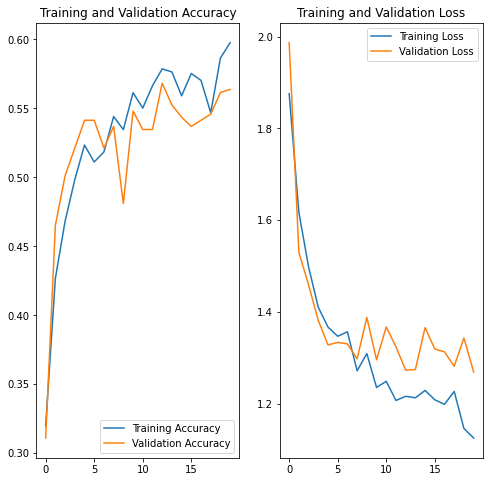

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings (Data Augmentation using Keras preprocessing layers)
1. the training and validation accuracy are much closer now signifying that the problem of overfitting has reduced significantly by using data augmentation
2. the model accuracy hasn't improved much, but compared to using ImageDataGenerator the training is much faster
3. will now look at the issue of class imbalance

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
count = [len(os.listdir(os.path.join(data_dir_train, sub_dir))) for sub_dir in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, sub_dir))]
sub_data_dir_train = [sub_dir for sub_dir in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, sub_dir))]
df = pd.DataFrame(list(zip(sub_data_dir_train, count)), columns=['Class', 'No. of Image'])
df

,Class,No. of Image
0,seborrheic keratosis,77
1,squamous cell carcinoma,181
2,melanoma,438
3,basal cell carcinoma,376
4,vascular lesion,139
5,actinic keratosis,114
6,dermatofibroma,95
7,nevus,357
8,pigmented benign keratosis,462


| Class                             | No. of Image | proportion |
|-----------------------------------|--------------|------------|
| seborrheic keratosis              | 77           | 3%         |
| squamous cell carcinoma           | 181          | 8%         |
| melanoma                         | 438          | 20%        |
| basal cell carcinoma              | 376          | 17%        |
| vascular lesion                  | 139          | 6%         |
| actinic keratosis                | 114          | 5%         |
| dermatofibroma                   | 95           | 4%         |
| nevus                            | 357          | 16%        |
| pigmented benign keratosis       | 462          | 21%        |


#### Findings: 
Class imbalance can be clearly seen

#### - Which class has the least number of samples?
- class **seborrheic keratosis** has the least number of samples <br>

#### - Which classes dominate the data in terms proportionate number of samples?
**pigmented benign keratosis**, **melanoma**, **basal cell carcinoma**, and **nevus** classes dominate the data in terms proportionate number of samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset='/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)
    p.zoom(probability=0.5, min_factor=0.8, max_factor=1.2)    
    p.sample(500)  ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7D70FF53A0>: 100%|██████████| 500/500 [00:21<00:00, 23.52 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7D8612C7F0>: 100%|██████████| 500/500 [00:24<00:00, 20.78 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7D70FEBC70>: 100%|██████████| 500/500 [00:18<00:00, 27.04 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2816x2112 at 0x7F7D8611DA60>: 100%|██████████| 500/500 [01:51<00:00,  4.48 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F7D86175700>: 100%|██████████| 500/500 [01:21<00:00,  6.13 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7D70FF8AF0>: 100%|██████████| 500/500 [00:18<00:00, 27.63 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7D8610E1C0>: 100%|██████████| 500/500 [00:44<00:00, 11.22 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7D70FFC670>: 100%|██████████| 500/500 [00:17<00:00, 28.74 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7D8610F250>: 100%|██████████| 500/500 [00:17<00:00, 27.99 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


it can be seen that augmentor has added 500 images for each class (500 * 9 = 4500)

In [32]:
jpg_files = []
for root, dirs, files in os.walk(data_dir_train):
    jpg_files.extend([os.path.join(root, file) for file in files if file.endswith('.jpg')])
len(jpg_files    )

6739

this takes the total number of training images available to 6739

### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
  for root, dirs, files in os.walk(data_dir_train):
      jpg_count = 0
      for file in files:
          if file.endswith(".jpg"):
              jpg_count += 1
      print(f"{root}: {jpg_count} jpg files")

/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train: 0 jpg files
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis: 77 jpg files
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output: 500 jpg files
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma: 181 jpg files
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output: 500 jpg files
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma: 438 jpg files
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output: 500 jpg files
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma: 376 jpg files
/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output: 500 jpg fil

| Class                             | No. of Image | proportion |
|-----------------------------------|--------------|------------|
| seborrheic keratosis              | 577          | 9%         |
| squamous cell carcinoma           | 681          | 10%        |
| melanoma                         | 938          | 14%        |
| basal cell carcinoma              | 876          | 13%        |
| vascular lesion                  | 639          | 9%         |
| actinic keratosis                | 614          | 9%         |
| dermatofibroma                   | 595          | 9%         |
| nevus                            | 857          | 13%        |
| pigmented benign keratosis       | 962          | 14%        |


1. So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.
2. it can be seen that for the class **seborrheic keratosis** with the least number of samples the sample proportion has increased from 3% to 9%
3. it can also be seen that for the class **pigmented benign keratosis** with the largest number of samples the sample proportion has decreased from 21% to 14%
4. By using data augmentation we have reduced the class imbalance from before

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    subset='training',
    validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    subset='validation',
    validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

1. image normalization is performed directly using Keras Rescaling layers.
2. we continue to use Keras preprocessing layers for data augmentation on top of data augmentation using Augmentor to handle class imbalance 
3. Have also added another convolution and pooling layer
4. Two dropout layers are used for increased regularization

In [43]:
model = tf.keras.Sequential([
  layers.Rescaling(1./255,input_shape=(img_height, img_width,3)),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2,fill_mode='nearest'),
  layers.RandomZoom(height_factor=0.2,fill_mode='nearest')
])

# add convolutional layer with 32 filters and a kernel size of 3x3
model.add(Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(img_height, img_width,3)))

# add max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer with 64 filters and a kernel size of 3x3
model.add(Conv2D(64, (3, 3), activation='relu', padding='valid'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer with 128 filters and a kernel size of 3x3
model.add(Conv2D(128, (3, 3), activation='relu', padding='valid'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer with 128 filters and a kernel size of 3x3
model.add(Conv2D(256, (3, 3), activation='relu', padding='valid'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add dropout layer
model.add(Dropout(0.4))

# add flatten layer
model.add(Flatten())

# add dense layer with 128 units and 'relu' activation
model.add(Dense(512, activation = "relu"))

# add dropout layer
model.add(Dropout(0.25))

# add output layer with 9 units and 'softmax' activation
model.add(Dense(9, activation = "softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                 

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

#### epochs = 100 
1. epochs = 100 is used instead of 30 as underfitting could be seen for epochs = 30
2. at epoch 30 training accuracy was 66% and validation accuracy was 68% and was increasing with every epoch
3. more epochs are needed as CNN model complexity has increased given the 10 layer CNN architecture with 11 million parameters 
4. even after 100 epoch it can be seen that overfitting is still not an issue

In [45]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
169/169 [==============================] - 13s 69ms/step - loss: 1.9349 - accuracy: 0.2513 - val_loss: 1.6422 - val_accuracy: 0.3541
Epoch 2/100
169/169 [==============================] - 11s 68ms/step - loss: 1.5714 - accuracy: 0.3958 - val_loss: 1.4998 - val_accuracy: 0.4068
Epoch 3/100
169/169 [==============================] - 11s 68ms/step - loss: 1.4873 - accuracy: 0.4295 - val_loss: 1.4077 - val_accuracy: 0.4514
Epoch 4/100
169/169 [==============================] - 11s 67ms/step - loss: 1.4199 - accuracy: 0.4470 - val_loss: 1.3382 - val_accuracy: 0.4714
Epoch 5/100
169/169 [==============================] - 11s 67ms/step - loss: 1.4267 - accuracy: 0.4473 - val_loss: 1.3549 - val_accuracy: 0.4707
Epoch 6/100
169/169 [==============================] - 11s 68ms/step - loss: 1.3495 - accuracy: 0.4726 - val_loss: 1.2853 - val_accuracy: 0.4967
Epoch 7/100
169/169 [==============================] - 11s 68ms/step - loss: 1.3515 - accuracy: 0.4737 - val_loss: 1.4044 - val_ac

#### **Todo:**  Visualize the model results

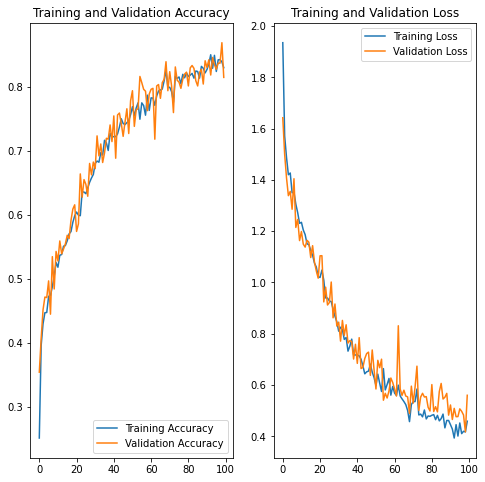

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Findings
1. after handling class imbalance **validation accuracy has significantly increased from 56% to 81%**
2. this is a result of handling class imbalance, and potentially the increase in CNN layers and the 2 dropout layers
3. it can be also seen that both training and validation accuracy keep increasing after every epoch
3. as a result we do further training of the existing model with 100 additional epochs

In [47]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
169/169 [==============================] - 11s 67ms/step - loss: 0.4515 - accuracy: 0.8253 - val_loss: 0.5517 - val_accuracy: 0.8181
Epoch 2/100
169/169 [==============================] - 11s 66ms/step - loss: 0.4018 - accuracy: 0.8437 - val_loss: 0.5155 - val_accuracy: 0.8359
Epoch 3/100
169/169 [==============================] - 11s 66ms/step - loss: 0.4227 - accuracy: 0.8377 - val_loss: 0.4967 - val_accuracy: 0.8255
Epoch 4/100
169/169 [==============================] - 12s 72ms/step - loss: 0.4330 - accuracy: 0.8351 - val_loss: 0.4607 - val_accuracy: 0.8352
Epoch 5/100
169/169 [==============================] - 12s 69ms/step - loss: 0.4207 - accuracy: 0.8379 - val_loss: 0.4500 - val_accuracy: 0.8545
Epoch 6/100
169/169 [==============================] - 11s 66ms/step - loss: 0.4192 - accuracy: 0.8359 - val_loss: 0.4744 - val_accuracy: 0.8567
Epoch 7/100
169/169 [==============================] - 11s 67ms/step - loss: 0.4115 - accuracy: 0.8429 - val_loss: 0.4489 - val_ac

#### **Todo:**  Visualize the model results

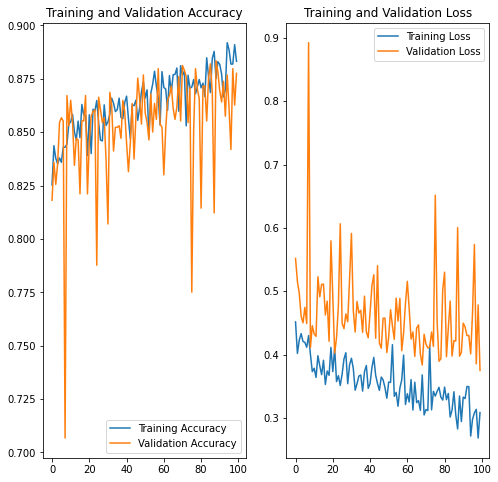

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
1. with a further 100 epochs it can be seen overfitting is still not an issue given the similar levels for training and validation accuracy at 88%
2. it can also be observed that further training with 100 epochs has resulted in **validation accuracy increasing from 81% to 88%**
3. given overfitting still does not seem to be an issue additional training with another 100 epochs can be considered for higher accuracy.

## Testing model performance on Test dataset

In [66]:
# create dataset object
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_test,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    shuffle='false',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123)

Found 118 files belonging to 9 classes.


In [61]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

4/4 [==============================] - 3s 25ms/step - loss: 6.9931 - accuracy: 0.4407
Test Accuracy: 0.4406779706478119


1. a much lower accuracy of 44% is seen on the test dataset comprising of 118 images
2. this is in comparison to 88% validation accuracy
2. as a result as an alternative a simpler CNN architecture is further explored

## Alternative : simpler CNN model

In [62]:
model = tf.keras.Sequential([
  layers.Rescaling(1./255,input_shape=(img_height, img_width,3)),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2,fill_mode='nearest'),
  layers.RandomZoom(height_factor=0.1,fill_mode='nearest')
])

# add convolutional layer with 32 filters and a kernel size of 3x3
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width,3)))

# add max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer with 64 filters and a kernel size of 3x3
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# add another convolutional layer with 128 filters and a kernel size of 3x3
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))


# add dropout layer
model.add(Dropout(0.2))

# add flatten layer
model.add(Flatten())

# add dense layer with 128 units and 'relu' activation
model.add(Dense(128, activation = "relu"))

# add dropout layer
#model.add(Dropout(0.25))

# add output layer with 9 units and 'softmax' activation
model.add(Dense(9, activation = "softmax"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                 

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [63]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [64]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
169/169 [==============================] - 11s 56ms/step - loss: 2.0390 - accuracy: 0.2224 - val_loss: 1.6930 - val_accuracy: 0.3437
Epoch 2/100
169/169 [==============================] - 9s 52ms/step - loss: 1.6109 - accuracy: 0.3926 - val_loss: 1.5575 - val_accuracy: 0.4172
Epoch 3/100
169/169 [==============================] - 8s 49ms/step - loss: 1.4701 - accuracy: 0.4457 - val_loss: 1.4504 - val_accuracy: 0.4581
Epoch 4/100
169/169 [==============================] - 8s 48ms/step - loss: 1.3938 - accuracy: 0.4700 - val_loss: 1.2903 - val_accuracy: 0.4937
Epoch 5/100
169/169 [==============================] - 8s 47ms/step - loss: 1.3149 - accuracy: 0.4939 - val_loss: 1.2938 - val_accuracy: 0.5056
Epoch 6/100
169/169 [==============================] - 10s 57ms/step - loss: 1.3069 - accuracy: 0.4894 - val_loss: 1.2771 - val_accuracy: 0.5033
Epoch 7/100
169/169 [==============================] - 8s 50ms/step - loss: 1.2694 - accuracy: 0.5082 - val_loss: 1.3560 - val_accurac

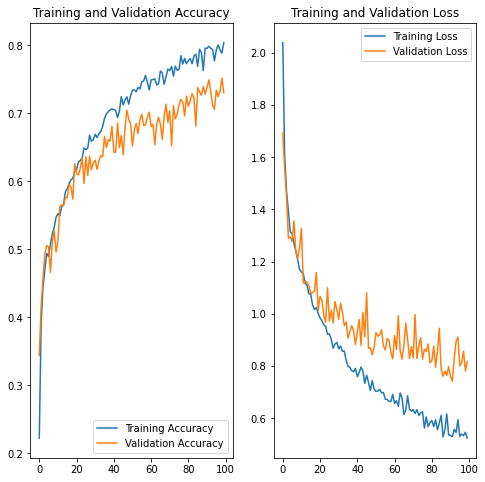

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1. we can see this model achieve a validation accuracy of 81%
2. the presence of slight overfitting is also becoming evident

#### Testing model performance on Test dataset

In [66]:
# create dataset object
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_test,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    shuffle='false',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123)

Found 118 files belonging to 9 classes.


In [67]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

4/4 [==============================] - 3s 61ms/step - loss: 6.6286 - accuracy: 0.4407
Test Accuracy: 0.4406779706478119


even with a simpler model a lower test accuracy of 44% is still being observed 